In [1]:
import socket, sys
socket.gethostname(), sys.executable


('login1', '/project/def-nahee/kbas/pone_offline/graphnet_env/bin/python')

# Results Analysis — Energy Reconstruction (Initiative 2)

This notebook analyses **test_predictions.csv** (event-level) and **metrics.csv** (epoch-level).

## 0. Setup


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Consistent plotting defaults (no subsampling anywhere in this notebook)
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})


Note: the energy model predicts **log10(E)**-space quantities, and `energy_pred` is reconstructed from that.


In [3]:
energy_test_predictions_path = Path("energy") / "test_predictions.csv"
energy_metrics_path =  Path("energy") /"metrics.csv"
df_energy_test_predictions = pd.read_csv(energy_test_predictions_path)
df_energy_metrics = pd.read_csv(energy_metrics_path)


## 1. Test Predictions (event-level)


### 1.1 Workflow
a) Confirm schema and NaNs/Infs  
b) Inspect the global residual distribution  
c) Inspect residual vs truth (trend + spread)  
d) Quantify resolution with **W** (equal-width and equal-population bins)  
e) Assess bias (median residual; and where relevant a ratio-based view)


### 1.2 Schema and integrity checks


In [4]:
print("shape:", df_energy_test_predictions.shape)
print("columns:", list(df_energy_test_predictions.columns))


shape: (41311, 7)
columns: ['true_energy', 'pred_energy', 'pred_log10_energy', 'true_log10_energy', 'residual_log10', 'residual', 'event_id']


In [5]:
df_energy_test_predictions.head(3)
## residual log10 negatif olunca residual da mi negatif olcak. isaretler hep tutarli mi olmali.


,true_energy,pred_energy,pred_log10_energy,true_log10_energy,residual_log10,residual,event_id
0,108859.773438,1304.831177,3.115554,5.036868,-1.921313,-107554.945312,242
1,14684.890625,26424.460938,4.422006,4.166871,0.255136,11739.570312,778
2,127.363152,229.665329,2.361095,2.105044,0.256052,102.302177,1171


In [6]:
print("Rows:", len(df_energy_test_predictions))

print("\nNaN counts (all columns):")
print(df_energy_test_predictions.isna().sum())


Rows: 41311

NaN counts (all columns):
true_energy          0
pred_energy          0
pred_log10_energy    0
true_log10_energy    0
residual_log10       0
residual             0
event_id             0
dtype: int64


In [7]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_energy_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


Inf counts (numeric columns):
                   +inf  -inf  any_inf
true_energy           0     0        0
pred_energy           0     0        0
pred_log10_energy     0     0        0
true_log10_energy     0     0        0
residual_log10        0     0        0
residual              0     0        0
event_id              0     0        0


### 1.3 Column ranges (min / max)


In [8]:
# Column ranges (min/max) for key fields
cols = [
    "true_energy",
    "pred_energy",
    "true_log10_energy",
    "pred_log10_energy",
    "residual",
    "residual_log10",
]
cols = [c for c in cols if c in df_energy_test_predictions.columns]

for c in cols:
    v = df_energy_test_predictions[c].to_numpy()
    print(f"{c:>16s}: {np.nanmin(v): .6g} .. {np.nanmax(v): .6g}")


     true_energy:  100.009 ..  9.97515e+06
     pred_energy:  83.4683 ..  8.72811e+06
true_log10_energy:  2.00004 ..  6.99892
pred_log10_energy:  1.92152 ..  6.94092
        residual: -9.91999e+06 ..  7.22622e+06
  residual_log10: -4.2638 ..  2.44268


In [9]:
# true_energy <= 0 check 
true_e = pd.to_numeric(df_energy_test_predictions["true_energy"], errors="coerce")
print("\ntrue_energy <= 0:", (true_e <= 0).sum())



true_energy <= 0: 0


### 1.4 Global summary (quantiles and W)


In [10]:
# ---- Energy: global W over the full test set ----
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")


p16=-0.3331, p50=0.0361, p84=0.3330, W=0.3331


### 1.5 Residual distribution


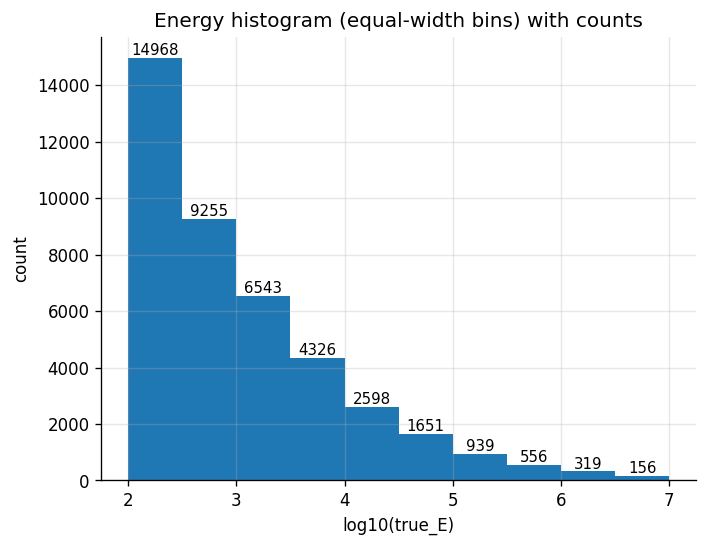

In [11]:
# ---- Energy: histogram with counts annotated on top of bars ----
n_bins_energy = 10
bins_energy = np.linspace(
    df_energy_test_predictions["true_log10_energy"].min(),
    df_energy_test_predictions["true_log10_energy"].max(),
    n_bins_energy + 1,
)
values = df_energy_test_predictions["true_log10_energy"].to_numpy()

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_energy)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("log10(true_E)")
plt.ylabel("count")
plt.title("Energy histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


### 1.6 Residual vs truth (trend + spread)

This diagnostic shows how the **log10 residual** behaves across the energy range:

- Each blue point is one event:  
  $r = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$  
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across energies.
- If it drifts above 0 → systematic **overestimation**.
- If it drifts below 0 → systematic **underestimation**.
- If the vertical spread increases with energy → **worsening resolution** (larger event-to-event scatter).


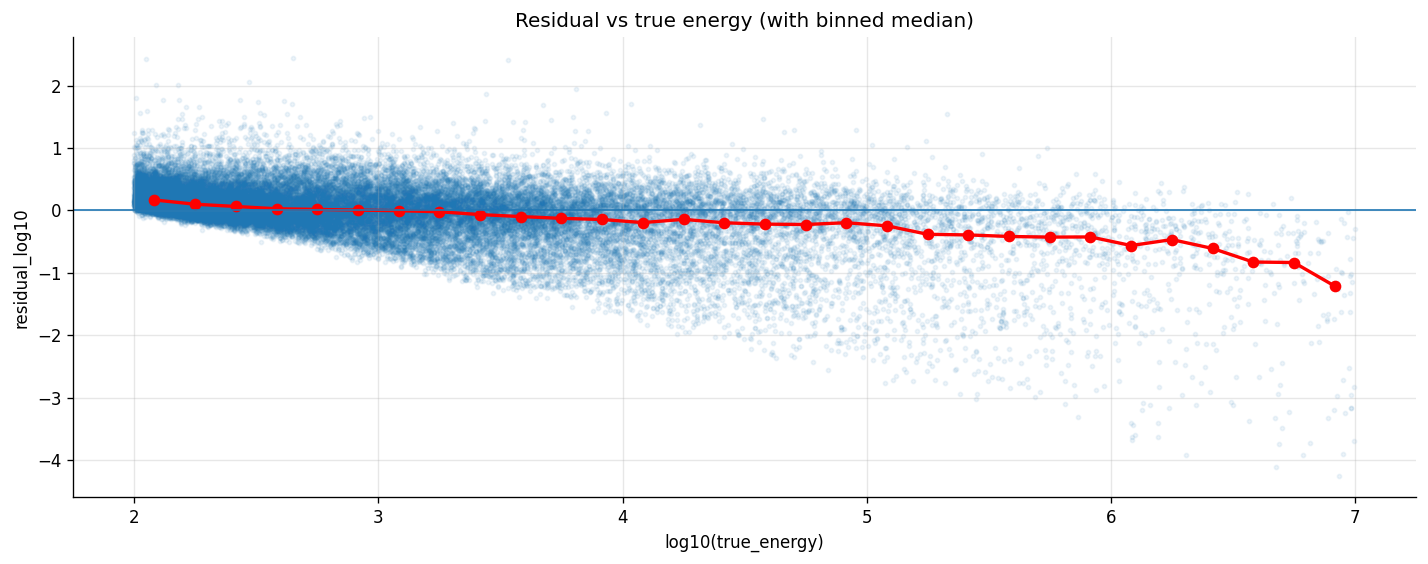

In [12]:
# ---- Energy: residual vs true_log10_energy scatter + binned median ----

x = df_energy_test_predictions["true_log10_energy"].to_numpy(dtype=float)

plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

# plot median curve
plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")

# reference line
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("log10(true_energy)")
plt.ylabel("residual_log10") # formulu yaz
plt.title("Residual vs true energy (with binned median)") # ismi degis
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 1.7 Calibration (predicted vs true)


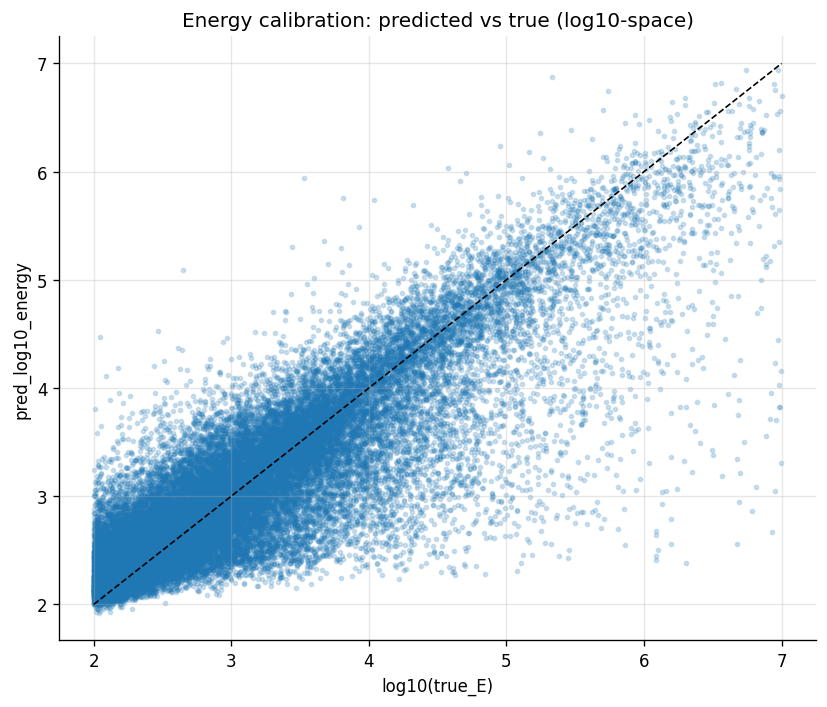

In [13]:
# ---- Energy: calibration scatter (pred_log10 vs true_log10) ----

plt.figure(figsize=(7, 6))  # bigger figure

plt.scatter(
    df_energy_test_predictions["true_log10_energy"],
    df_energy_test_predictions["pred_log10_energy"],
    s=6, alpha=0.2
)

xmin = df_energy_test_predictions["true_log10_energy"].min()
xmax = df_energy_test_predictions["true_log10_energy"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x in black

plt.xlabel("log10(true_E)")
plt.ylabel("pred_log10_energy")
plt.title("Energy calibration: predicted vs true (log10-space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
df_energy_w_rows = []
for left, right in zip(edges[:-1], edges[1:]):
    # select events in this bin (match matplotlib hist logic: [left, right) except last bin includes right)
    if right == edges[-1]:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] <= right)
    else:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] < right)

    r = df_energy_test_predictions.loc[mask, "residual_log10"].to_numpy(dtype=float)

    # skip empty bins (shouldn't happen, but safe)
    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_energy_w_rows.append({
        "Ebin": f"({left:.3f}, {right:.3f}]",
        "E_center_log10": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table = pd.DataFrame(df_energy_w_rows)
df_energy_W_table


,Ebin,E_center_log10,count,p16,p50,p84,W
0,"(2.000, 2.500]",2.249981,14968,-0.039980,0.121663,0.391246,0.215613
1,"(2.500, 3.000]",2.749870,9255,-0.240017,0.017413,0.360552,0.300284
2,"(3.000, 3.500]",3.249758,6543,-0.465842,-0.026594,0.308365,0.387104
3,"(3.500, 4.000]",3.749646,4326,-0.675252,-0.118374,0.243436,0.459344
4,"(4.000, 4.499]",4.249534,2598,-0.933898,-0.178518,0.231711,0.582804
5,"(4.499, 4.999]",4.749422,1651,-1.114398,-0.219723,0.176588,0.645493
6,"(4.999, 5.499]",5.249311,939,-1.361345,-0.312060,0.106992,0.734169
7,"(5.499, 5.999]",5.749199,556,-1.611363,-0.421862,0.042575,0.826969
8,"(5.999, 6.499]",6.249087,319,-1.627831,-0.549575,-0.120278,0.753776
9,"(6.499, 6.999]",6.748975,156,-2.560874,-0.948087,-0.361069,1.099902


### 1.8 Resolution vs truth (W)


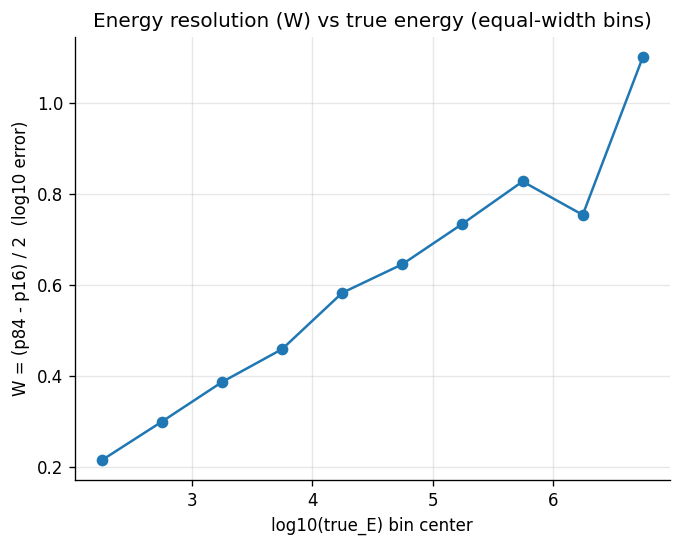

In [15]:
# ---- Energy: plot W vs true energy (equal-width bins) ----

plt.figure()
plt.plot(df_energy_W_table["E_center_log10"], df_energy_W_table["W"], marker="o")
plt.xlabel("log10(true_E) bin center")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


#### Interpreting the W trend (equal-width bins)

In the **equal-width** energy binning, the number of events per bin is **not uniform**.  
At higher energies the bins contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens rapidly with energy.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [16]:
# ---- create equal-population bins (qcut) ----

n_qbins_energy = 10

df_energy_test_predictions["Ebin_q"] = pd.qcut(
    df_energy_test_predictions["true_log10_energy"],
    q=n_qbins_energy,
    duplicates="drop",
)


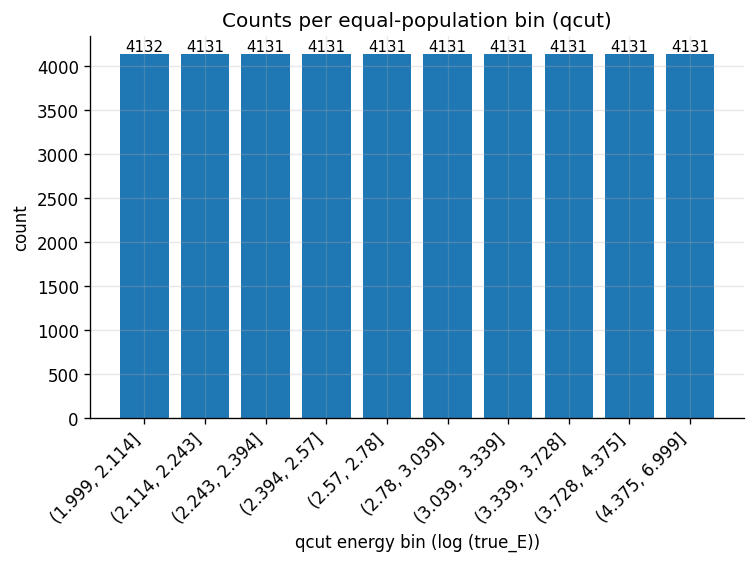

In [17]:
# ----  plot counts per qcut bin ----

bin_counts_q = df_energy_test_predictions["Ebin_q"].value_counts().sort_index()

plt.figure()
bars = plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(range(len(bin_counts_q)), [str(i) for i in bin_counts_q.index], rotation=45, ha="right")
plt.xlabel("qcut energy bin (log (true_E))")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


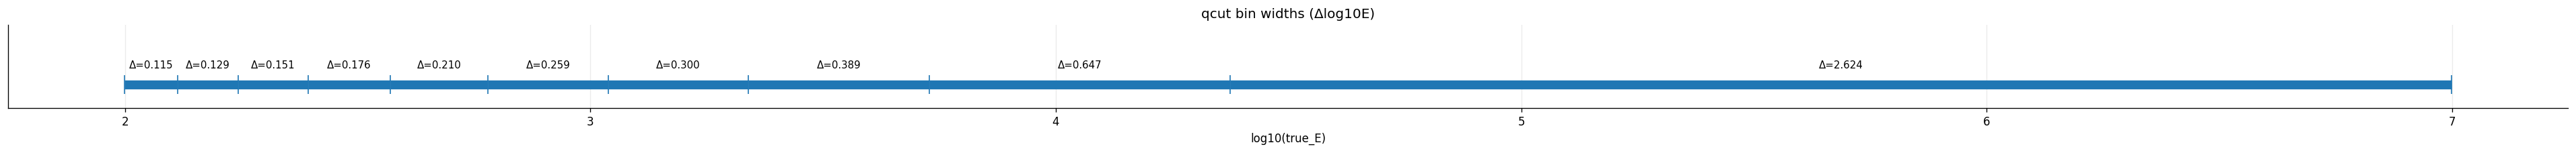

In [18]:
# ---- Visualize qcut bin widths only (in log10-space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("log10(true_E)")
plt.title("qcut bin widths (Δlog10E)")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [19]:
# ---- Energy: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_energy_q = []
for iv, g in df_energy_test_predictions.groupby("Ebin_q", observed=True):
    r = g["residual_log10"].to_numpy(dtype=float)

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_energy_q.append({
        "Ebin_q": str(iv),
        "E_center_log10": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table_q = pd.DataFrame(rows_energy_q).sort_values("E_center_log10")
df_energy_W_table_q


,Ebin_q,E_center_log10,count,p16,p50,p84,W
0,"(1.999, 2.114]",2.0565,4132,0.053324,0.174799,0.438328,0.192502
1,"(2.114, 2.243]",2.1785,4131,-0.020107,0.123263,0.389874,0.204990
2,"(2.243, 2.394]",2.3185,4131,-0.084058,0.082668,0.344137,0.214097
3,"(2.394, 2.57]",2.4820,4131,-0.144289,0.044346,0.351413,0.247851
4,"(2.57, 2.78]",2.6750,4131,-0.218288,0.022105,0.363914,0.291101
5,"(2.78, 3.039]",2.9095,4131,-0.319238,0.002304,0.363002,0.341120
6,"(3.039, 3.339]",3.1890,4131,-0.446737,-0.015704,0.322578,0.384658
7,"(3.339, 3.728]",3.5335,4131,-0.583240,-0.087077,0.264182,0.423711
8,"(3.728, 4.375]",4.0515,4131,-0.812416,-0.154978,0.236856,0.524636
9,"(4.375, 6.999]",5.6870,4131,-1.297753,-0.321412,0.124068,0.710911


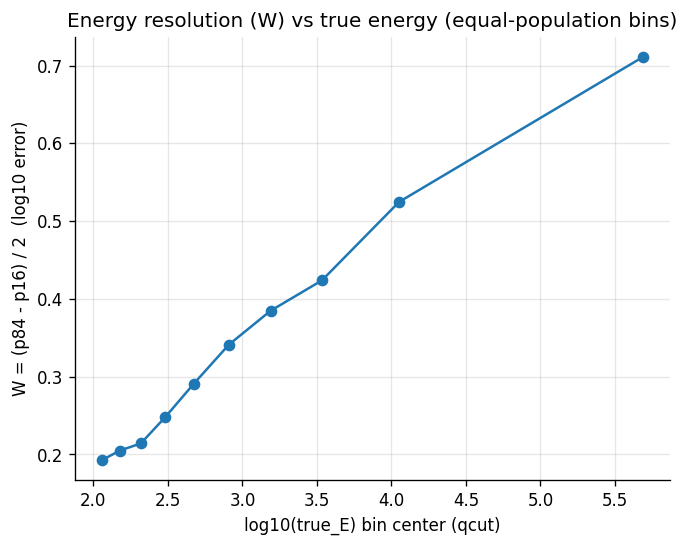

In [20]:
# ---- Energy: plot W vs true energy (qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["W"], marker="o")
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()



#### Why `residual_log10`?

I analyze the prediction error in **log10-space** using `residual_log10`.  
This is especially convenient when the energy spans many orders of magnitude.


#### Definition of `residual_log10`

`residual_log10` is defined as:

$ \mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true}) $

In the CSV this corresponds to:

$ \mathrm{residual\_log10} = \mathrm{pred\_log10\_energy} - \log_{10}(\mathrm{true\_energy}) $


#### Interpreting the sign of `residual_log10`

- `residual_log10 = 0` → perfect prediction  
- `residual_log10 > 0` → the model **overpredicts** energy  
- `residual_log10 < 0` → the model **underpredicts** energy


#### Quantiles: p16, p50, p84

To summarize the distribution of `residual_log10`:

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If the residuals were Gaussian, these would roughly correspond to **±1σ** around the median.)


#### Resolution proxy: W

I define a resolution-like width using the central 68% interval:

$ W = \frac{p84 - p16}{2} $

Interpretation:
- **Small W** → tighter residual distribution → **better resolution**
- **Large W** → wider residual distribution → **worse resolution**

**Note:** W is measured in **log10-error units**, not directly in “% error”.


So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the `residual_log10` distribution in each energy bin.

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the energy, and does this depend on energy?


#### Bias diagnostics: two complementary views



a - **Median residual vs energy**  
   Plot $p50(\mathrm{residual\_log10})$ as a function of energy.  
   This is the most direct bias measure in log-space.

b - **Median pred/true ratio vs energy**  
   Convert the median residual into a multiplicative ratio  
   $\mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50}$  
   to make the bias more intuitive.


#### View A: median residual vs energy (log-space bias)

If we define  
$\mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$,

then:

- $p50 \approx 0$ → unbiased in that energy region  
- $p50 > 0$ → overestimation  
- $p50 < 0$ → underestimation


### 1.9 Bias diagnostics


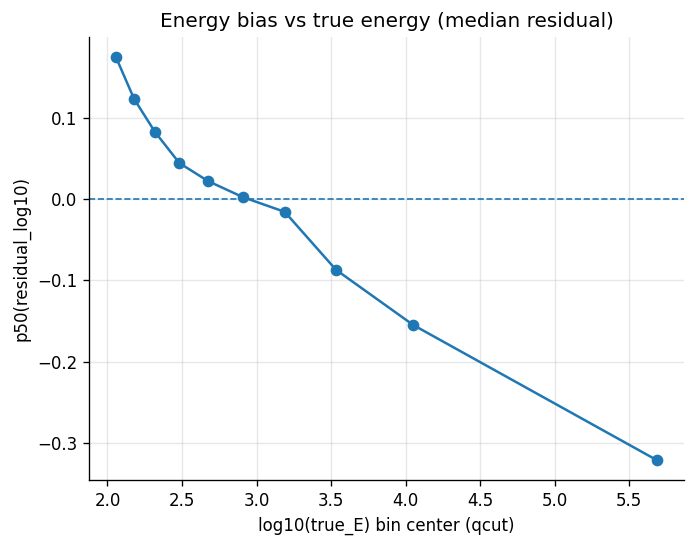

In [21]:
# ----  bias vs true energy (median residual, qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("p50(residual_log10)")
plt.title("Energy bias vs true energy (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


#### View B: median pred/true ratio vs energy (pred/true)

Because the residual is in log10-space, it can be converted into a multiplicative ratio:

$ \frac{E_\mathrm{pred}}{E_\mathrm{true}} = 10^{\mathrm{residual\_log10}} $

So the median bias ratio per bin is:

$ \mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50} $

Interpretation:
- ratio ≈ 1 → unbiased
- ratio < 1 → underestimation
- ratio > 1 → overestimation


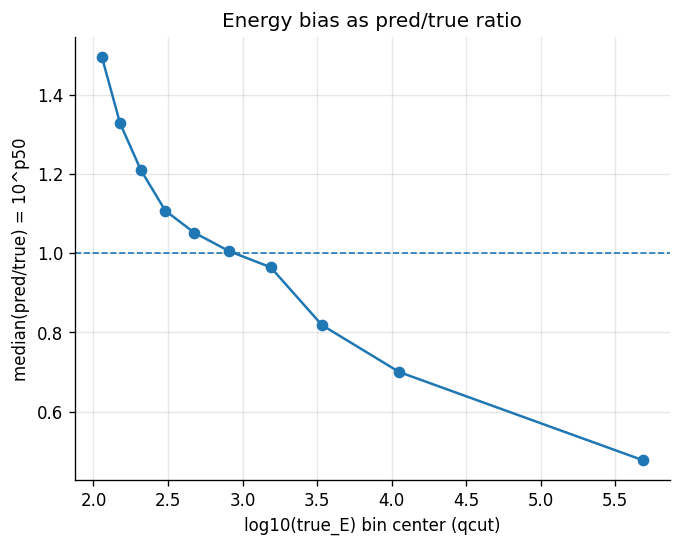

In [22]:
# ---- bias as pred/true ratio (qcut bins) ----

df_energy_W_table_q["ratio50"] = 10 ** (df_energy_W_table_q["p50"])

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["ratio50"], marker="o")
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("median(pred/true) = 10^p50")
plt.title("Energy bias as pred/true ratio")
plt.grid(True, alpha=0.3)
plt.show()


## 2. Training Metrics (epoch-level)


### 2.1 Overview


In [23]:
print("shape:", df_energy_metrics.shape)
print("columns:", list(df_energy_metrics.columns))


shape: (24, 12)
columns: ['epoch', 'train_loss', 'val_loss', 'lr', 'best_model_is_updated', 'val_residual_log10_p16', 'val_residual_log10_p50', 'val_residual_log10_p84', 'val_W_log10', 'val_bias_log10', 'val_mae_log10', 'val_rmse_log10']


In [24]:
# Identify the epoch where the best model was last updated
if "best_model_is_updated" in df_energy_metrics.columns:
    _mask = df_energy_metrics["best_model_is_updated"].astype(bool)
    best_epoch = int(df_energy_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
else:
    best_epoch = None

print(f"Best-model epoch (last update): {best_epoch}")


Best-model epoch (last update): 18


In [25]:
df_energy_metrics.head(5)


,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_log10_p16,val_residual_log10_p50,val_residual_log10_p84,val_W_log10,val_bias_log10,val_mae_log10,val_rmse_log10
0,0,NaN,0.133194,0.000983,True,-0.608409,-0.068521,0.282597,0.445503,-0.174334,0.393560,0.586177
1,1,0.372996,0.118524,0.000950,True,-0.311982,0.155236,0.503219,0.407601,0.073620,0.389003,0.536795
2,2,0.122783,0.111499,0.000916,True,-0.421117,0.047654,0.377915,0.399516,-0.038418,0.360633,0.526252
3,3,0.112578,0.106869,0.000883,True,-0.462739,-0.037332,0.311837,0.387288,-0.098670,0.349118,0.514470
4,4,0.105935,0.106451,0.000849,True,-0.458195,-0.008948,0.312301,0.385248,-0.090549,0.345556,0.515086


### 2.2 Training curves (loss & LR)


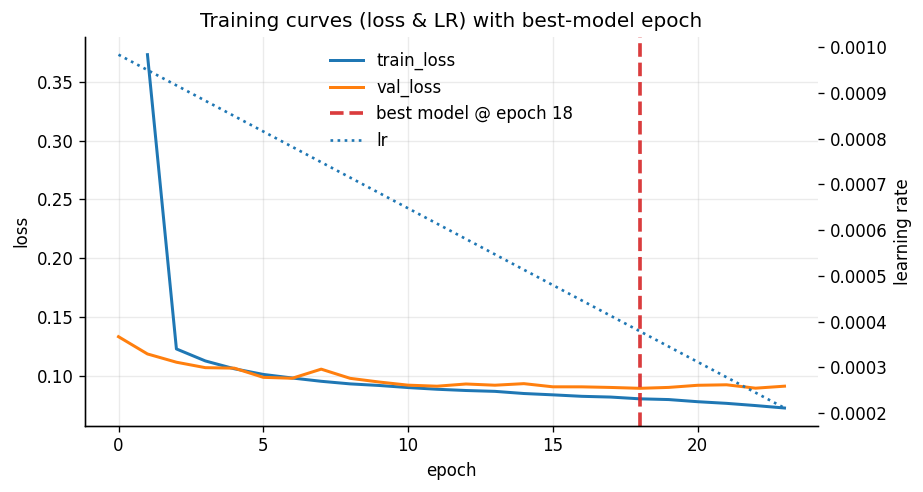

In [26]:
fig, ax = plt.subplots(figsize=(7.8, 4.2))

ax.plot(df_energy_metrics["epoch"], df_energy_metrics["train_loss"], label="train_loss", linewidth=1.8)
ax.plot(df_energy_metrics["epoch"], df_energy_metrics["val_loss"], label="val_loss", linewidth=1.8)

# Best-model epoch (last update)
if "best_model_is_updated" in df_energy_metrics.columns:
    _mask = df_energy_metrics["best_model_is_updated"].astype(bool)
    _best_epoch = int(df_energy_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
else:
    _best_epoch = None

if _best_epoch is not None:
    ax.axvline(
        _best_epoch,
        color="tab:red",
        linestyle="--",
        linewidth=2.2,
        alpha=0.9,
        label=f"best model @ epoch {_best_epoch}",
    )

ax.set_xlabel("epoch")
ax.set_ylabel("loss")

ax2 = None
if "lr" in df_energy_metrics.columns:
    ax2 = ax.twinx()
    ax2.plot(df_energy_metrics["epoch"], df_energy_metrics["lr"], label="lr", linestyle=":", linewidth=1.6)
    ax2.set_ylabel("learning rate")
    ax2.grid(False)

# Combined legend
handles, labels = ax.get_legend_handles_labels()
if ax2 is not None:
    h2, l2 = ax2.get_legend_handles_labels()
    handles += h2
    labels += l2
ax.legend(handles, labels, loc="best")

ax.set_title("Training curves (loss & LR) with best-model epoch")
fig.tight_layout()
plt.show()


### 2.3 Key validation metrics over epochs


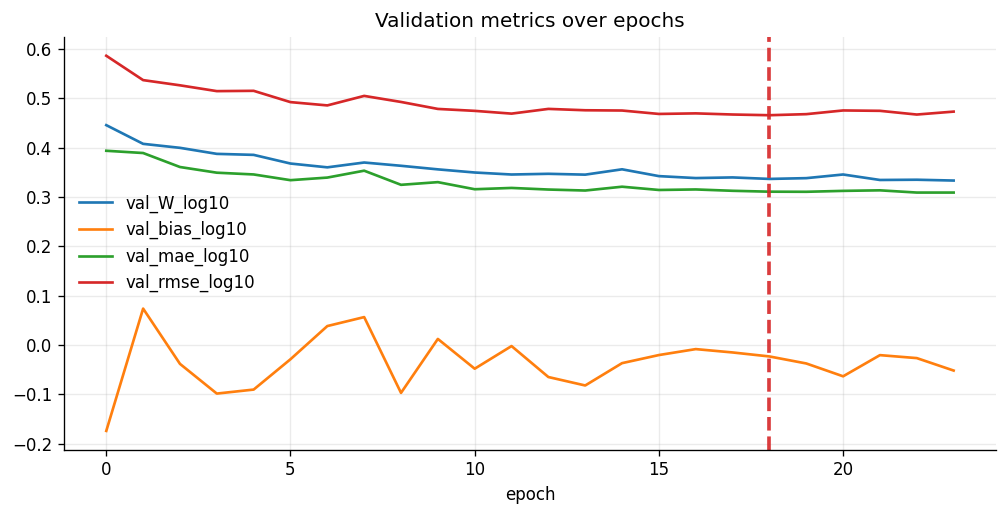

In [27]:
# Key validation metrics over epochs (from metrics.csv)
cols_to_plot = ["val_W_log10", "val_bias_log10", "val_mae_log10", "val_rmse_log10"]
cols_to_plot = [c for c in cols_to_plot if c in df_energy_metrics.columns]

plt.figure(figsize=(8.5, 4.4))
for col in cols_to_plot:
    plt.plot(df_energy_metrics["epoch"], df_energy_metrics[col], label=col, linewidth=1.6)

if "best_model_is_updated" in df_energy_metrics.columns:
    _mask = df_energy_metrics["best_model_is_updated"].astype(bool)
    _best_epoch = int(df_energy_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
    if _best_epoch is not None:
        plt.axvline(_best_epoch, color="tab:red", linestyle="--", linewidth=2.2, alpha=0.9)

plt.xlabel("epoch")
plt.title("Validation metrics over epochs")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### 2.4 Snapshot (best vs last epoch)


In [28]:
# Best-epoch vs last-epoch snapshot (epoch-level metrics)
_last = df_energy_metrics.tail(1).copy()
_last.insert(0, "which", "last_epoch")

if best_epoch is not None:
    _best = df_energy_metrics.loc[df_energy_metrics["epoch"] == best_epoch].tail(1).copy()
    _best.insert(0, "which", "best_epoch")
    snapshot = pd.concat([_best, _last], ignore_index=True)
else:
    snapshot = _last

snapshot


,which,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_log10_p16,val_residual_log10_p50,val_residual_log10_p84,val_W_log10,val_bias_log10,val_mae_log10,val_rmse_log10
0,best_epoch,18,0.080379,0.089317,0.000379,True,-0.337953,0.033247,0.335026,0.336490,-0.023388,0.310632,0.465644
1,last_epoch,23,0.072570,0.091126,0.000211,False,-0.367328,0.003861,0.299053,0.333191,-0.051992,0.308839,0.472951
